In [2]:
%matplotlib inline
import os, sys, glob
import numpy as np
from matplotlib import pyplot as plt
import mrcfile

# package up sometime?
sys.path.append('../src/')
import simutils
import cryoemio

# CryoEM Images

CryoEM data is often stored directly from a detector as either a .mrc or .tif file. In both cases, these are often called movies - because the detector often takes a rapid succession of images (frames) and stores them all into one file.

These individual movies can be rather large; it is common for a modern camera to be taking 4,000 x 4,000 pixel images or greater for each frame. It is also typical to store 10's of frames per movie. As a direct result of this, the typical (compressed) movie size if often 100's MB's each.

In a typical single particle analysis experiment, one may take 1,000's of such movies. It is not uncommon for a single experiment to there take a few terabytes of data just for the raw data.



# Loading a full image

Loading a bunch of images...

# Managing dataset

TODO: pre-load full dataset (.tiff or .mrcs) into hdf5 so we can access efficiently

the idea would be to consider a dataset as an immuable object that we access without rewriting new files. 
For example, say an experiment consists of 1000 4000x4000 micrographs, this is stored in a single hdf5 file, and each particle has 3 coordinates (micrograph number and pixel origin) a box size and a binning value.


# Particles

It is necessary to extract the particles of interest from the frames/movies and work on this data separately in order to determine the volume (density map) of the particle under consideration. Here we show how to manipulate and view the particles.

We have assumed that the particles were extracted using a tools like relion.

## Load particles stacks

We define a variable DATADIR below that points to some example data

In [4]:
DATADIR = '/gpfs/slac/cryo/fs1/g/ML/cryoEM-notebooks/data/20181005-rib-TEM4/Extract/extract_one_2dclass/Micrographs'

We shall use a library called mrcfile that will load the data into a numpy array into the variable MRCSFILE. It is convention to keep particle images that have been extracted from the stacks in a file with extension .mrcs. We shall keep the read data in the numpy array PARTICLES.

In [11]:
MRCSFILE = DATADIR+'/Hasan_00871_aligned_DW.mrcs'

In [12]:
PARTICLES = None
with mrcfile.open(MRCSFILE) as mrc:
    PARTICLES = mrc.data
mrcfile.close()

Let's show get a feeling for what it looks like: we see that PARTICLES consistens of 9 images, each of which is 540x540px. Each individual image is an extracted particle of the same class (ie it has been determined from cross-correlation that all of these 10 particle images are of the same particle projection and orientation)

In [58]:
PARTICLES.shape

(9, 540, 540)

Okay, let's actually show some graphics.... we use the standard mpl

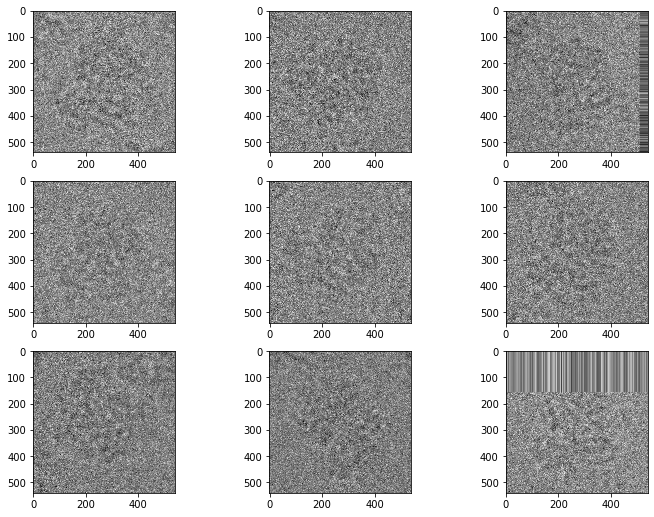

In [62]:
fig = plt.figure(figsize=(12, 12))
for i in range( 0, PARTICLES.shape[0] ):
    fig.add_subplot( 4, 3, i+1 )
    plt.imshow( PARTICLES[i], cmap='Greys' )
plt.show()

Looks like the 3 and 9th image have some issues..... so lets remove them for now

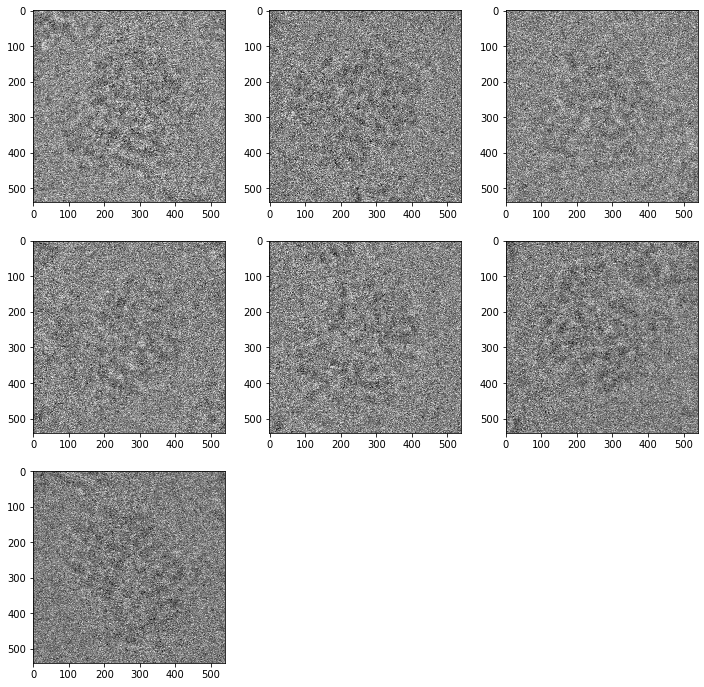

In [78]:
FILTERED_PARTICLES = np.delete( PARTICLES, [8,2], axis=0 )
FILTERED_PARTICLES.shape
fig = plt.figure(figsize=(12, 12))
for i in range( 0, FILTERED_PARTICLES.shape[0] ):
    fig.add_subplot( 3, 3, i+1 )
    plt.imshow( FILTERED_PARTICLES[i], cmap='Greys' )
plt.show()

Lets take an average to see if we can make sense out of the aggregate

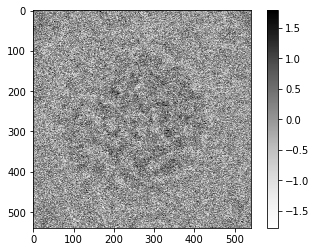

In [79]:
plt.imshow( np.mean( FILTERED_PARTICLES,axis=0 ), cmap='Greys' )
plt.colorbar()

<a id='loadfulldataset'></a>
## Load a full dataset of extracted particles

In [3]:
DATADIR = '/gpfs/slac/cryo/fs1/g/ML/cryoEM-notebooks/data/20181005-rib-TEM4/Extract/extract_one_2dclass/Micrographs'

We load all particles from the `.mrcs` files founds in `DATADIR` and store them in a single `.hdf5` file

In [4]:
mrcs_list = glob.glob(DATADIR+'/*.mrcs')
h5_file   = DATADIR+'/particles.h5'
#
cryoemio.mrclist2hdf5( mrc_list=mrcs_list, h5_file=h5_file, verbose=True)

/gpfs/slac/cryo/fs1/g/ML/cryoEM-notebooks/data/20181005-rib-TEM4/Extract/extract_one_2dclass/Micrographs/Hasan_01692_aligned_DW.mrcs (3, 540, 540)
/gpfs/slac/cryo/fs1/g/ML/cryoEM-notebooks/data/20181005-rib-TEM4/Extract/extract_one_2dclass/Micrographs/Hasan_00276_aligned_DW.mrcs (3, 540, 540)
/gpfs/slac/cryo/fs1/g/ML/cryoEM-notebooks/data/20181005-rib-TEM4/Extract/extract_one_2dclass/Micrographs/Hasan_00827_aligned_DW.mrcs (1, 540, 540)
/gpfs/slac/cryo/fs1/g/ML/cryoEM-notebooks/data/20181005-rib-TEM4/Extract/extract_one_2dclass/Micrographs/Hasan_03949_aligned_DW.mrcs (1, 540, 540)
/gpfs/slac/cryo/fs1/g/ML/cryoEM-notebooks/data/20181005-rib-TEM4/Extract/extract_one_2dclass/Micrographs/Hasan_00195_aligned_DW.mrcs (1, 540, 540)
/gpfs/slac/cryo/fs1/g/ML/cryoEM-notebooks/data/20181005-rib-TEM4/Extract/extract_one_2dclass/Micrographs/Hasan_04611_aligned_DW.mrcs (2, 540, 540)
/gpfs/slac/cryo/fs1/g/ML/cryoEM-notebooks/data/20181005-rib-TEM4/Extract/extract_one_2dclass/Micrographs/Hasan_07177_a

To load the data stored in the resulting `.hdf5` file, do:

In [5]:
data = cryoemio.loadhdf5(h5_file, verbose=True)

List of datasets in .hdf5 file:
particles


Let's see how many particles we have, of what dimensions:

In [31]:
print('(N_particles, N_x, N_y) = {0}'.format(data['particles'].shape))

(N_particles, N_x, N_y) = (8278, 540, 540)


Let's visualize them now. Since it might take a while, we slice first.

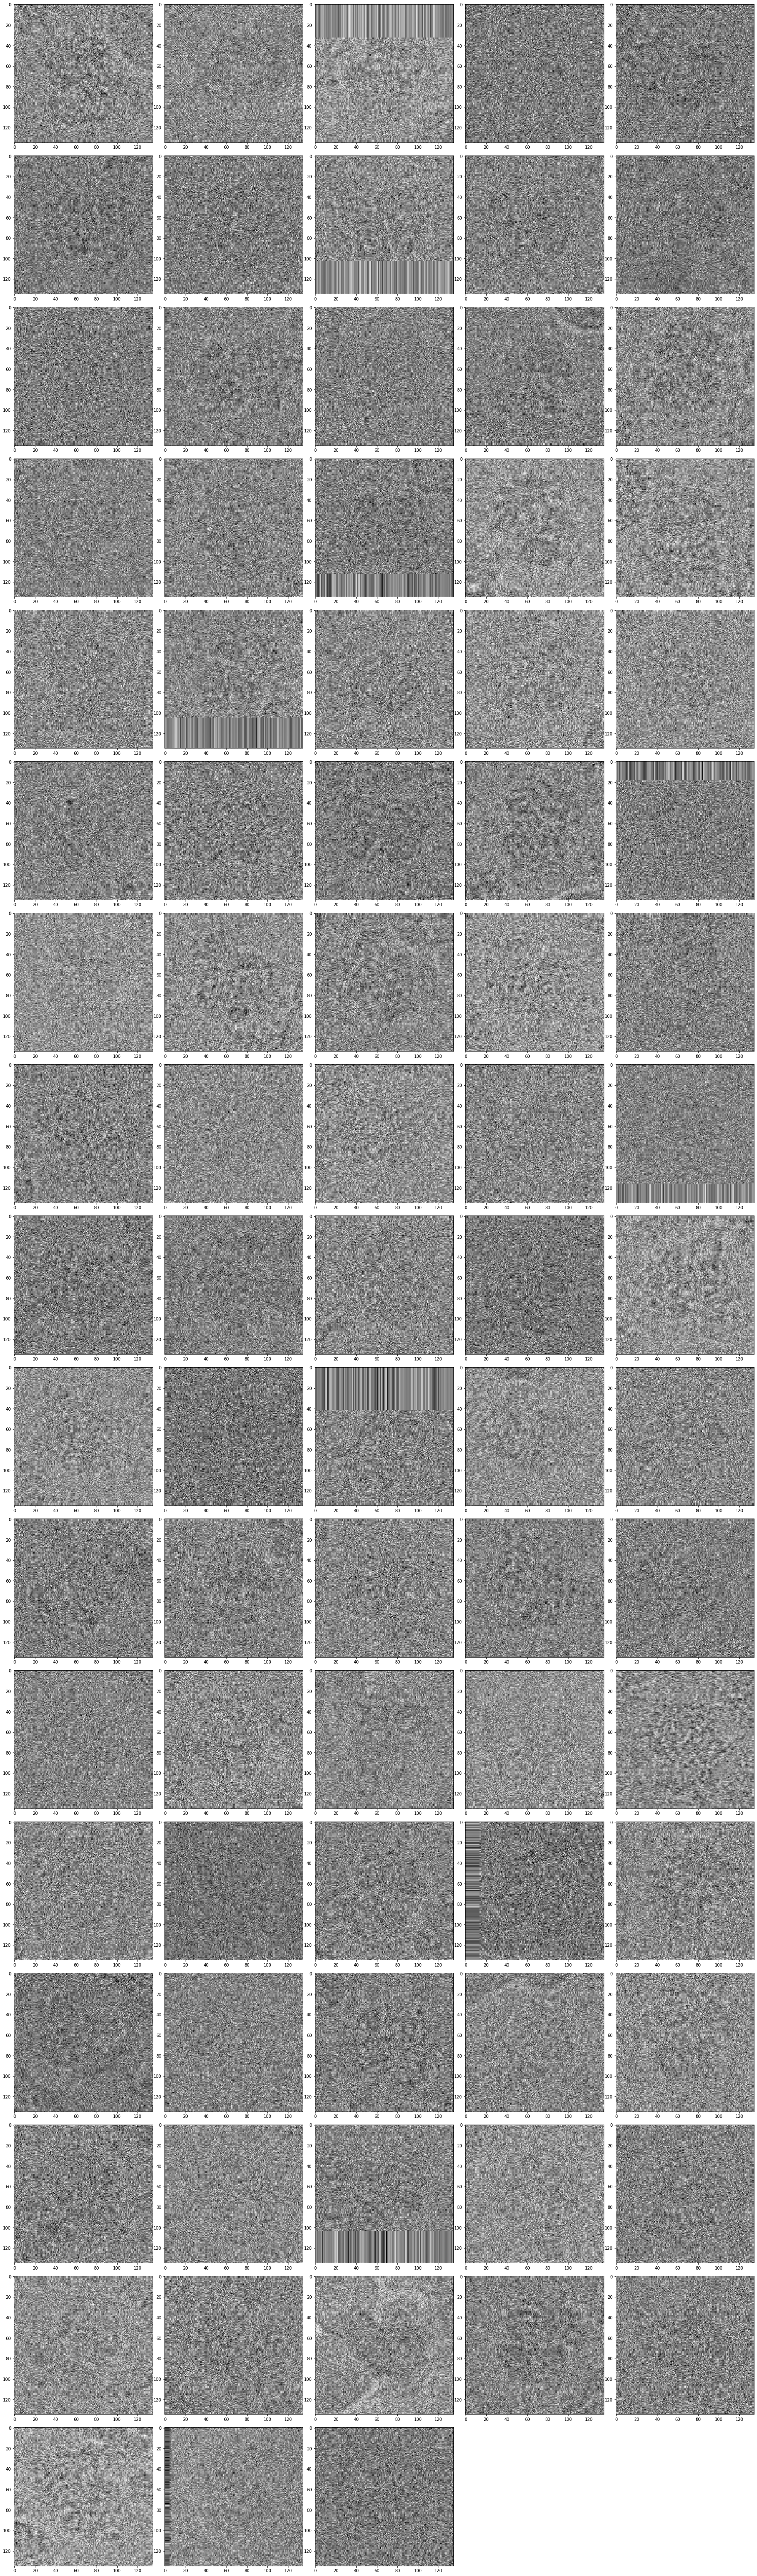

In [30]:
view_particles(data['particles'], slicing=(100,4,4))